# Example of a classification task using RNN

For a similar example, see also:

> NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN
by Sean Robertson on [pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

## Data task
We work on a collection of dates represented with different formats. The task is to associate each date with the correct month, in spite of the date format.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv('../data/rome_dates.csv', index_col=0)

In [3]:
data.head(20)

,text,target,day,month,year,temperature,temperature_class
0,01-01-1960,1960-01-01,1,1,1960,3.638,1
1,01/01/1960,1960-01-01,1,1,1960,3.638,1
2,01.01.1960,1960-01-01,1,1,1960,3.638,1
3,01/01/1960,1960-01-01,1,1,1960,3.638,1
4,01.01.1960,1960-01-01,1,1,1960,3.638,1
5,"Fri 01, Jan 1960",1960-01-01,1,1,1960,3.638,1
6,"Jan 01, 1960",1960-01-01,1,1,1960,3.638,1
7,"Fri 01, January 1960",1960-01-01,1,1,1960,3.638,1
8,1960/01/01,1960-01-01,1,1,1960,3.638,1
9,1960 January 01,1960-01-01,1,1,1960,3.638,1


### Get a subset of dates with month names

In [4]:
from datetime import datetime

In [5]:
selected_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
                'October', 'November', 'December']
date_list, month_list, dates_list = data.text.values, data.month.values, data.target.values
dataset = []
for i, d in enumerate(date_list):
    for m in selected_months:
        if m in d:
#            dt = datetime.strptime(dates_list[i], '%Y-%m-%d')
            parts = d.split(m)
            dataset.append(("{}{}".format(parts[0], m), month_list[i]))
            break

In [6]:
dataset[:6]

[('Fri 01, January', 1),
 ('1960 January', 1),
 ('Sat 02, January', 1),
 ('1960 January', 1),
 ('Sun 03, January', 1),
 ('1960 January', 1)]

## Prepare data
In this example, we read each date (text) as a **sequence of chars** represented according to the one-hot encoding scheme.

In [7]:
import string
import torch

### Date strings to PyTorch tensors

In [8]:
alphabet = string.ascii_letters + string.digits + " -./,"

In [9]:
def date2tensor(date_text):
    tensor = torch.zeros(len(date_text), 1, len(alphabet))
    for i, char in enumerate(date_text):
        tensor[i][0][alphabet.find(char)] = 1
    return tensor

def tensor2date(date_tensor):
    return "".join([alphabet[x] for x in torch.nonzero(date_tensor)[:,2]])

#### Example

In [10]:
dt = date2tensor('Sun 03, January')
td = tensor2date(dt)

In [11]:
dt.size()

torch.Size([15, 1, 67])

In [13]:
dt[:2]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [14]:
td

'Sun 03, January'

## RNN network structure

![rnn](../data/rnn.png)

In [15]:
import torch.nn as nn

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [27]:
hidden_size = 20
rnn = RNN(len(alphabet), hidden_size, len(selected_months))

### Forward step

In [28]:
date_tensor = date2tensor('Sun 03, January')
hidden_tensor = rnn.init_hidden()

In [29]:
hidden_tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
for row in date_tensor:
    print(hidden_tensor)
    output, next_hidden = rnn(row, hidden_tensor)
    hidden_tensor = next_hidden


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ 0.0326, -0.0471,  0.0329,  0.1933, -0.1075,  0.1800,  0.0175, -0.1763,
          0.0797, -0.1224,  0.0221, -0.0435, -0.1754, -0.0356, -0.1243, -0.1013,
          0.0635,  0.0726, -0.1142, -0.0064]], grad_fn=<AddmmBackward0>)
tensor([[ 0.1490, -0.0427, -0.0318,  0.0779,  0.0677,  0.0213, -0.0089, -0.0437,
         -0.0243, -0.0995,  0.0553, -0.0087, -0.1151,  0.0134, -0.1209, -0.0357,
          0.0256, -0.0323,  0.0290, -0.0691]], grad_fn=<AddmmBackward0>)
tensor([[ 0.1156,  0.0155, -0.0221,  0.0221,  0.0333,  0.0575, -0.0543, -0.1838,
         -0.0082,  0.0018,  0.0261, -0.0743, -0.0764,  0.0200, -0.1297, -0.1039,
         -0.0122,  0.1431, -0.0256,  0.1240]], grad_fn=<AddmmBackward0>)
tensor([[-0.0077, -0.1386, -0.1580,  0.0887, -0.0592,  0.1048, -0.0786, -0.1543,
          0.0683, -0.1339,  0.0010,  0.0258, -0.2006, -0.0260, -0.1074,  0.0065,
         -0.0125,  0.0098,  0.0005, -0.036

In [36]:
np.argmax(output.detach().numpy())

3

In [21]:
output

tensor([[-2.4898, -2.3999, -2.4217, -2.4723, -2.4922, -2.4576, -2.6016, -2.4105,
         -2.4600, -2.5774, -2.5384, -2.5195]], grad_fn=<LogSoftmaxBackward0>)

In [24]:
next_hidden

tensor([[-0.0688,  0.0552, -0.0560,  0.1276, -0.0835,  0.0165,  0.0184, -0.0424,
         -0.1049,  0.0020, -0.0171,  0.0209, -0.0953, -0.0699, -0.0433, -0.0680,
          0.0229, -0.0702,  0.0183,  0.1033,  0.1129, -0.0376, -0.0101, -0.0170,
         -0.0475, -0.0346, -0.1104, -0.0433, -0.0345, -0.0650,  0.0186,  0.0437,
         -0.0024, -0.0226,  0.0457, -0.0193, -0.0234, -0.0408, -0.0281, -0.1152,
          0.0841, -0.0063,  0.0054,  0.0787,  0.0177,  0.0176, -0.0910, -0.0762,
          0.0451, -0.0458, -0.0034,  0.0105,  0.1248, -0.0629, -0.0761,  0.0353,
         -0.0327, -0.0611, -0.0075,  0.0545, -0.0375, -0.1028,  0.0496,  0.0581,
         -0.0138, -0.1097,  0.0010,  0.0012,  0.0690, -0.0561,  0.0278,  0.0300,
          0.0308,  0.0437, -0.0180,  0.1074,  0.0683, -0.0813,  0.0254, -0.0209,
          0.0874, -0.0042, -0.0612, -0.0428,  0.0426,  0.0084,  0.0659,  0.1052,
          0.0028, -0.0357,  0.0956, -0.0800, -0.0739,  0.0053, -0.0345, -0.0526,
          0.0643, -0.1037, -

## Training

In [37]:
def output2month(output):
    top_n, top_i = output.topk(1)
    return selected_months[top_i[0].item()]

In [38]:
output2month(output)

'April'

### Create a training data generator

In [39]:
def create_training():
    date_string, month = dataset[np.random.choice(range(len(dataset)))]
    date_tensor = date2tensor(date_string)
    target_tensor = torch.tensor([month-1], dtype=torch.long)
    return date_tensor, target_tensor, date_string, month

In [40]:
input_t, target, date_string, month = create_training()
print(target, date_string, month)

tensor([6]) Fri 21, July 7


### Training

In [41]:
loss_function = nn.NLLLoss()
learning_rate = 0.005

In [42]:
def train(target_tensor, date_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    for i in range(date_tensor.size()[0]):
        output, hidden = rnn(date_tensor[i], hidden)
    loss = loss_function(output, target_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

#### Example

In [43]:
date_tensor, target_tensor, date_text, month = create_training()
output, loss = train(target_tensor, date_tensor)

In [44]:
loss

2.6065595149993896

In [45]:
print(date_text)
print(tensor2date(date_tensor))
print(output2month(output))

1969 May
1969 May
April


### Training with more data

In [46]:
hidden_size = 128
rnn = RNN(len(alphabet), hidden_size, len(selected_months))

In [47]:
epochs = 3000
error_history = []
run = list(enumerate(range(epochs)))
e = 0
log_period = 50

for i, epoch in tqdm(run):
    date_tensor, target_tensor, date_text, month = create_training()
    output, loss = train(target_tensor, date_tensor)
    e += loss
    if i > 0 and i % log_period == 0:
        error_history.append(e / log_period)
        e = 0

  0%|          | 0/3000 [00:00<?, ?it/s]

#### Plot error rate

In [48]:
import matplotlib.pyplot as plt

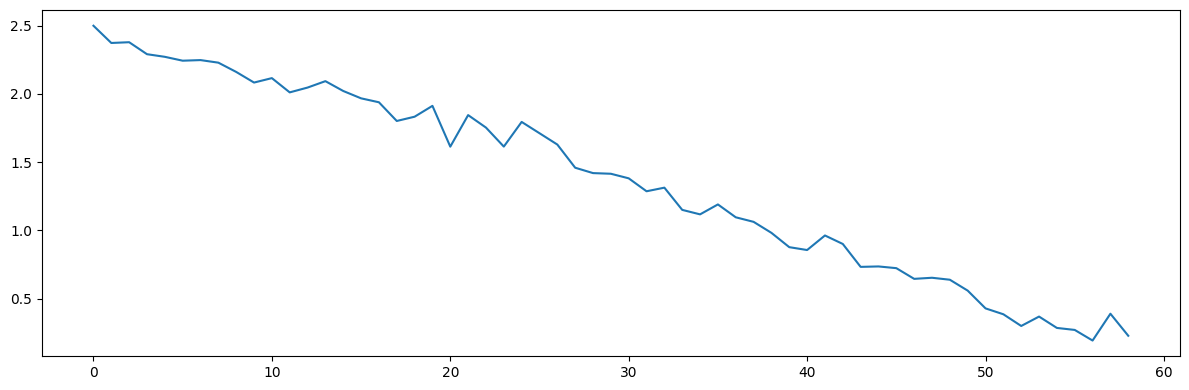

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(error_history)
plt.tight_layout()
plt.show()

## Test and evaluate

### Test

In [50]:
def predict(date_text):
    hidden = rnn.init_hidden()
    date_tensor = date2tensor(date_text)
    for char_tensor in date_tensor:
        output, hidden = rnn(char_tensor, hidden)
    return output

def output2month(output):
    return int(output.argmax() + 1)

In [53]:
output2month(predict('Tue 27, February'))

2

In [54]:
sample = np.random.choice([x for x, y in dataset], 10)
for d in sample:
    print(d, "month is", output2month(predict(d)))

Tue 29, April month is 4
1995 September month is 9
1994 October month is 10
Tue 13, November month is 12
Fri 05, November month is 12
1991 September month is 9
1981 September month is 9
Tue 01, August month is 8
1962 February month is 2
1983 August month is 8


In [55]:
output2month(predict('Christmass is on December'))

2

In [56]:
output2month(predict('3012 ril'))

4

### Evaluate

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [58]:
y_true, y_pred = [], []
for i in range(2000):
    date_tensor, target_tensor, date_text, month = create_training()
    y_true.append(selected_months[month-1])
    p = output2month(predict(date_text))
    y_pred.append(selected_months[p-1])

In [59]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       April       1.00      1.00      1.00       160
      August       1.00      1.00      1.00       161
    December       0.54      1.00      0.70       153
    February       1.00      1.00      1.00       164
     January       1.00      1.00      1.00       141
        July       1.00      1.00      1.00       132
        June       1.00      1.00      1.00       137
       March       1.00      1.00      1.00       159
         May       1.00      1.00      1.00       383
    November       0.00      0.00      0.00       130
     October       1.00      1.00      1.00       130
   September       1.00      1.00      1.00       150

    accuracy                           0.94      2000
   macro avg       0.88      0.92      0.89      2000
weighted avg       0.90      0.94      0.91      2000



In [60]:
cm = confusion_matrix(y_true, y_pred, labels=selected_months)

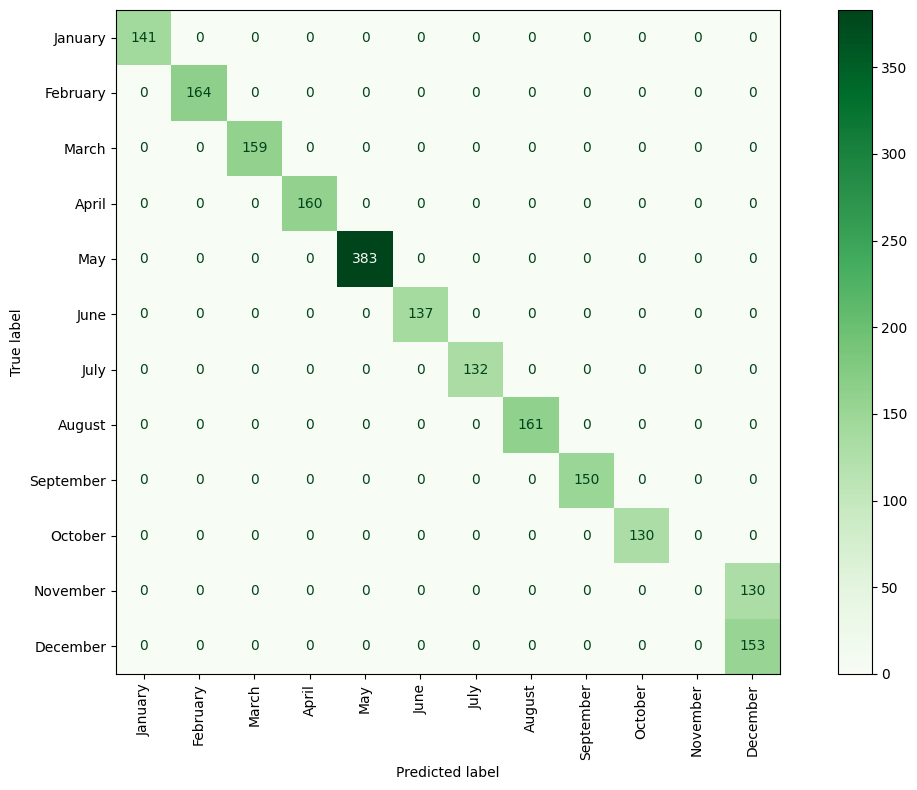

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
dis = ConfusionMatrixDisplay(cm, display_labels=selected_months)
dis.plot(ax=ax, cmap='Greens', xticks_rotation='vertical')
plt.tight_layout()
plt.show()